In [197]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import skimage.io as io
import pickle

import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
#for colab
from tensorflow.keras.optimizers import Adam

# from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from tensorflow.keras.layers import BatchNormalization,Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from keras.regularizers import l2
from keras import backend as K

from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix, classification_report


# Loading data
a function that loads the images locations and labels.<br>
input: the data path.<br>
output:<br>
&emsp;&emsp;dataHiero -> a dataframe with index= location of images and label= their labels <br>
&emsp;&emsp;img_groups -> a dictionary in the shape of { "label" : [array of locations of images labeled with this label] }

In [ ]:
path="../GlyphDataset/Dataset/Manual/Preprocessed/"

def loadData(folderPictures=path):
    
    folders=next(os.walk(folderPictures))[1]
    img_groups = {}
    img_list={}

    for folder in folders:
        for img_file in os.listdir(folderPictures+folder):
            name, label = img_file.strip('.png').split("_")
            
            
            # One image per class

            #if label not in img_groups.keys():
            #    img_groups[label] = [folder + "_" + name]


            # Multiple images per class

            if label in img_groups.keys():
                img_groups[label].append(folder+"_"+name)
            else:
                img_groups[label] = [folder+"_"+name]

            img_list[folder+"_"+name]=[label]


    # Remove class with only one hieroglyph


    for k,v in list(img_groups.items()):
        if len(v)==1: del img_groups[k]

    # Extract only N hieroglyph classes randomly

    nclass = len(img_groups.keys())

    list_of_class = random.sample(list(img_groups.keys()), nclass)
#     print(list_of_class)

    short_dico = {x: img_groups[x] for x in list_of_class if x in img_groups}

    dataHiero=pd.DataFrame.from_dict(img_list,orient='index')
    dataHiero.columns = ["label"]
    dataHiero = dataHiero[dataHiero.label != 'UNKNOWN']

    dataHiero = dataHiero.loc[dataHiero['label'].isin(short_dico)]


    dataHiero.reset_index(level=0, inplace=True)

    return dataHiero,img_groups

a function that takes the image groups and load those images<br>
input: img_proups dictionary<br>
output:<br>
&emsp;&emsp;X -> np array of the images<br>
&emsp;&emsp;y -> np array of labels<br>
&emsp;&emsp;glyph_sizes -> a dictionary in the form of {'label' : (starting index, ending index in X and y)}


In [ ]:
def read_images(img_groups,path):
    X=[]
    y=[]
    glyph_sizes={}
    low=0
    for glyph in img_groups:
        category_images=[]
        high=low
        for img_path in img_groups[glyph] :
            folder,name = img_path.split('_')
            image = io.imread(path+folder+'/'+name+'_'+glyph+'.png')
            X.append(image)
            y.append(glyph)
            high+=1
#         X.append(np.array(category_images))
        glyph_sizes[glyph]=(low,high-1)
        low=high
        
    return np.array(X),np.array(y).reshape((-1,1)),glyph_sizes
            
    

In [ ]:
dataHiero,img_groups=loadData(folderPictures=path)
dataHiero.head()
# img_groups

,index,label
0,39_390115,D21
1,39_390082,M17
2,39_390292,V31
3,39_390375,U15
4,39_390175,D35


In [ ]:
X,y,sizes=read_images(img_groups,path)

In [ ]:
len(np.unique(y))

135

In [ ]:
type(X)
print(y.shape)
print(X.shape)
sizes['D21'][1]

(2921, 1)
(2921, 75, 50)


5

saving the images into a pickle

In [ ]:
#train val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

In [ ]:
X_test.shape

(1252, 75, 50)

In [ ]:
def get_sizes(X,Y):
    sizes={}
    for i ,(x,y) in enumerate(zip(X,Y)):
#         print(i,x,y)
        if y[0] in sizes:
            sizes[y[0]].append(i)
        else:
            sizes[y[0]]=[i]
    return sizes
    

In [ ]:
sizes=get_sizes(X_train,y_train)
X=X_train
y=y_train

In [ ]:
#saving data as pickle
with open("train.pickle", "wb") as f:
    pickle.dump((X,y,sizes),f)

In [ ]:
sizes_val=get_sizes(X_test,y_test)
Xval=X_test
yval=y_test

In [ ]:
#saving data as pickle
with open("test.pickle", "wb") as f:
    pickle.dump((Xval,yval,sizes_val),f)

**Creating all pairs**

In [99]:
def create_all_pairs(X,y):
    n=y.shape[0]
    _,w,h=X.shape
    input1_ind=[]
    input2_ind=[]
    label=[]
    for i in range(n):
        for j in range(i+1,n):
            if y[i] == y[j]:
                  label.append(1)
            else:
                label.append(0)

            input1_ind.append(i)
            input2_ind.append(j)



    label=np.asarray(label)
    input1,input2,label = shuffle(input1_ind,input2_ind,label)
    pairs=[input1,input2]

    return X,np.asarray(pairs),np.asarray(label)

In [100]:
images_all_train,pairs_all_train,labels_all_train=create_all_pairs(X,y)

In [101]:
images_all_test,pairs_all_test,labels_all_test=create_all_pairs(Xval,yval)

In [102]:
print(pairs_all_test.shape)
pairs_all_train.shape

(2, 783126)


(2, 4264660)

In [103]:
print(labels_all_train[labels_all_train==0].shape)
labels_all_train[labels_all_train==1].shape

(4090789,)


(173871,)

In [104]:
with open(data_path+"pairs_all_train.pickle", "wb") as f:
    pickle.dump((images_all_train,pairs_all_train,labels_all_train),f)

In [105]:
with open(data_path+"pairs_all_test.pickle", "wb") as f:
    pickle.dump((images_all_test,pairs_all_test,labels_all_test),f)

# reading the Data with pickle

In [2]:
#colab
data_path= '/content/drive/MyDrive/hiero_cv/'
#local|
# data_path='./'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with open(data_path+"train.pickle", "rb") as f:
    (X,y,sizes) = pickle.load(f)

In [5]:
with open(data_path+"test.pickle", "rb") as f:
    (Xval,yval,sizes_val) = pickle.load(f)

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [71]:
#read all pairs train
with open(data_path+"pairs_all_train.pickle", "rb") as f:
    (images_all_train,pairs_all_train,labels_all_train) = pickle.load(f)

In [72]:
#read all pairs test
with open(data_path+"pairs_all_test.pickle", "rb") as f:
    (images_all_test,pairs_all_test,labels_all_test) = pickle.load(f)

In [73]:
labels_all_train.shape

(4264660,)

# The Model

In [251]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape,name='Input_1')
    right_input = Input(input_shape,name='Input_2')
    
    # Convolutional Neural Network
    model = Sequential(name='CNN')
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu',  kernel_regularizer=l2(2e-4)))
    model.add(Flatten())

    model.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(1e-3)))
    # model.add(Dropout(0.2))
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]),name='Subtract')
    
    L1_distance = L1_layer([encoded_l, encoded_r])
    L1_distance = Dense(512,activation='relu',kernel_regularizer=l2(1e-3),name='Dense_1')(L1_distance)
    L1_distance = Dense(256,activation='relu',kernel_regularizer=l2(1e-3),name='Dense_2')(L1_distance)
    # Add a dense layer with a sigmoid unit to generate the similarity score

    prediction = Dense(1,activation='sigmoid',name='Output')(L1_distance)

    
    
    # prediction = Lambda(cosine_distance, output_shape=1)([encoded_l, encoded_r])
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [252]:
model = get_siamese_model((75, 50, 1))
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_1 (InputLayer)           [(None, 75, 50, 1)]  0           []                               
                                                                                                  
 Input_2 (InputLayer)           [(None, 75, 50, 1)]  0           []                               
                                                                                                  
 CNN (Sequential)               (None, 4096)         4891712     ['Input_1[0][0]',                
                                                                  'Input_2[0][0]']                
                                                                                                  
 Subtract (Lambda)              (None, 4096)         0           ['CNN[0][0]',             

In [253]:
optimizer = Adam(lr = 0.001)
model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


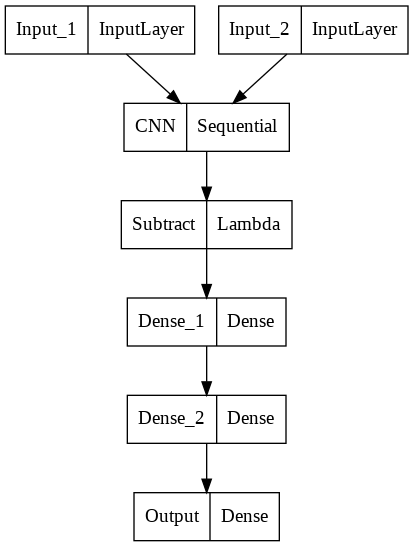

In [31]:
tf.keras.utils.plot_model(
    model, to_file='model.png',
    show_layer_names=True, rankdir='TB'
)



# Functions

## a function to predict which glyph

In [13]:
def create_glyphlist(X,sizes):
    images=[]
    labels=[]
    _,w,h=X.shape
    for glyph in sizes:
        # index=sizes[glyph][0]
        if glyph != 'UNKNOWN':
            index = np.random.choice(sizes[glyph])
            images.append(X[index].reshape( w , h, 1))
            labels.append(glyph)
    return np.asarray(images), np.asarray(labels) 

In [14]:
anchor_img, anchor_label=create_glyphlist(X,sizes)

**a function that create pairs from the image that we want to test and the anchor list**

In [15]:
def whichGlyph_pair(image,anchor_img,anchor_label):
    N,w,h,_=anchor_img.shape
#     pairs=[np.zeros((N, w, h,1)) for i in range(2)]
    
    test_image= np.asarray([image]*N).reshape(N, w, h,1)
    
    anchor_label, test_image, anchor_img = shuffle(anchor_label, test_image, anchor_img)
#     pairs = [test_image,anchor_img]
    
    return test_image, anchor_img, anchor_label
    

**a funnction that compairs the image with each character from the anchor list and outputs the propabilities.**

In [16]:
def whichGlyph(model,image,anchor_img,anchor_label):
    test_image,anchor_img,targets = whichGlyph_pair(image,anchor_img,anchor_label)
    probs = model.predict([test_image,anchor_img])
    return probs,anchor_img,targets
    

## creating pairs of images

**a function that create pairs of images with a certain batch size with y= 1 if they are similar and 0 if they are different.**

In [17]:
def createPairs(X,y,sizes,batch_size):
    ##create a batch with half it's size are similar glyphs and the other half are different.
    n=0
    i=0
    
    label=[]
    _,w,h=X.shape
    # initialize 2 empty arrays for the input image batch
#     pairs=[np.zeros((batch_size, w, h,1)) for i in range(2)]
    input1=np.zeros((batch_size, w, h,1))
    input2=np.zeros((batch_size, w, h,1))
    
    while n < batch_size:
        random_key1=random.choice(list(sizes))
#         low=sizes[random_key1][0]
#         high=sizes[random_key1][1]
        index1, index3 = np.random.choice(sizes[random_key1], size=2)
        index2 = np.random.choice(sizes[random_key1])
        
        random_key2=random.choice(list(sizes))
        
        while random_key2 == random_key1:
            random_key2=random.choice(list(sizes))
            
#         low=sizes[random_key2][0]
#         high=sizes[random_key2][1]
        index4=np.random.choice(sizes[random_key2])
        n += 2
        # appending images 1 and 3 into input1 and input2 corresponding to y=1 
        #and images 2 and 4 corresponding to y=0
    
        input1[i,:,:,:] = X[index1].reshape( w , h, 1)
        input1[i+1,:,:,:] = X[index2].reshape(w, h, 1)
        input2[i,:,:,:] = X[index3].reshape(w, h, 1)
        input2[i+1,:,:,:] = X[index4].reshape(w, h, 1)
        i += 2
#         input1+=[X[index1],X[index2]]
#         input2+=[X[index3],X[index4]]
        label+=[1,0]
        
#         print(index1,index2,index3,index4)
#         print(y[index1],y[index2],y[index3],y[index4])
#         print(random_key1,random_key2)
    input1,input2,label = shuffle(input1,input2,label)
    pairs=[input1,input2]
    
    return pairs,label
pairs,label=createPairs(X,y,sizes,32)   

In [151]:
def get_batch_all(images,pairs_all,labels_all,batch_size,it):
    _,w,h=images.shape
    input1=np.zeros((batch_size, w, h,1))
    input2=np.zeros((batch_size, w, h,1))
    # label=np.zeros((batch_size,1))
    index=0
    start=it*batch_size
    end= it*batch_size + batch_size
    for i in range(start,end):
      # random_index=random.choice(range(batch_size))
      ind1=pairs_all[0][i]
      ind2=pairs_all[1][i]
      input1[index,:,:,:] = images[ind1].reshape( w , h, 1)
      input2[index,:,:,:] = images[ind2].reshape( w , h, 1)
      index+=1

    input1,input2,label = shuffle(input1,input2,labels_all[start:end])
    pairs=[input1,input2]
    
    return pairs,label


In [150]:
# pp,mm=get_batch_all(images_all_train,pairs_all_train,labels_all_train,5)

## Testing

### Testing accuracy random

In [19]:
def calc_accuracy(N,Xval,yval,anchor_img,anchor_label,model,sizes):
    count_first=0
    count_first3=0
    for i in range(N):
        # ind=random.choice(range(yval.shape[0]))
        random_key = random.choice(list(sizes))
        ind = np.random.choice(sizes[random_key])
                               
        predicted,anchor_imgs,targets=whichGlyph(model,Xval[ind],anchor_img,anchor_label)
        sort_index = np.argsort(np.asarray(predicted).reshape(len(predicted),))
        if targets[sort_index[-1]] == yval[ind][0]:
            count_first+=1
        if yval[ind][0] in targets[sort_index[127:]]:
            count_first3+=1
    accuracy_first=count_first/N
    accuracy_first3=count_first3/N
    
    return accuracy_first, accuracy_first3

In [20]:
def predict_random(N,Xval,yval,anchor_img,anchor_label,model,sizes):
    preds=[]
    actual=[]
    for i in range(N):
        # ind=random.choice(range(yval.shape[0]))
        random_key = random.choice(list(sizes))
        ind = np.random.choice(sizes[random_key])
        
        predicted,anchor_imgs,targets=whichGlyph(model,Xval[ind],anchor_img,anchor_label)
        sort_index = np.argsort(np.asarray(predicted).reshape(len(predicted),))
        preds.append(targets[sort_index[-1]])
        actual.append(yval[ind][0])
        
    
    return np.asarray(preds),np.asarray(actual)

**a function to test accuracy**

In [21]:
def test_accuracy_score(N,Xval,yval,anchor_img,anchor_label,model,sizes):
    count_first=0
    for i in range(N):
        random_key = random.choice(list(sizes))
        ind = np.random.choice(sizes[random_key])
        
#         ind=random.choice(range(yval.shape[0]))
        predicted,anchor_imgs,targets=whichGlyph(model,Xval[ind],anchor_img,anchor_label)
        if targets[np.argmax(predicted)]== yval[ind][0]:
            count_first+=1
    percent_correct = (100.0 * count_first / N)
    print("Got an average of {}% accuracy in {} samples. \n".format(percent_correct,N))
    return percent_correct

## Under sampling

In [106]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
#undersampling training data

in_df=pd.DataFrame({'0':pairs_all_train[0],'1':pairs_all_train[1]})
in_df,labels_tr= rus.fit_resample(in_df,labels_all_train)
p0,p1,labels_tr= shuffle(in_df['0'].to_numpy(),in_df['1'].to_numpy(),labels_tr)
pairs_all_train=[p0,p1] 
labels_all_train= labels_tr

#undersampling test data

test_df=pd.DataFrame({'0':pairs_all_test[0],'1':pairs_all_test[1]})
test_df,labels_te= rus.fit_resample(test_df,labels_all_test)
p0t,p1t,labels_te=shuffle(test_df['0'].to_numpy(),test_df['1'].to_numpy(),labels_te)
pairs_all_test= [p0t,p1t]
labels_all_test=labels_te


In [166]:
labels_all_train.shape

(347742,)

In [76]:
print(labels_all_train[labels_all_train==0].shape)
print(labels_all_train[labels_all_train==1].shape)

(173871,)
(173871,)


# Training

In [202]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 128 #64#32
n_iter = 2000 #5400 # No. of training iterations 20000
N_way = 20 # how many classes for testing one-shot tasks
n_val = 256 # how many one-shot tasks to validate on
best = -1
epochs=2


In [192]:
labels_all_train.shape

(347742,)

In [193]:
model_path = './weights/'
# model_2_path= '/content/drive/MyDrive/hiero_cv/'
# model_cos_path= '/content/drive/MyDrive/hiero_cv/weights_cos/'
# model_regul='/content/drive/MyDrive/hiero_cv/regul_weights/'


In [203]:
print("Training on all pairs!")
print("-------------------------------------")
train_loss=[]
validation_loss=[]
t_start = time.time()

for epoch in range(epochs):
    test_it=0
    pairs_all_train[0],pairs_all_train[1],labels_all_train=shuffle(pairs_all_train[0],pairs_all_train[1],labels_all_train)
    pairs_all_test[0],pairs_all_test[1],labels_all_test=shuffle(pairs_all_test[0],pairs_all_test[1],labels_all_test)
    for i in range(1, n_iter+1):
        (inputs,targets) = get_batch_all(images_all_train,pairs_all_train,labels_all_train,batch_size,i)
        targets=np.asarray(targets)
        loss = model.train_on_batch(inputs, targets)
        train_loss.append(loss[0])
        if i % evaluate_every == 0:
            print("\n ------------- \n")
            print("Time for {0} iterations epoch :{1} : {2} mins".format(i, epoch,(time.time()-t_start)/60.0))
            print(f"Train Loss: {loss[0]} , accuracy : {loss[1]}") 
    #         val_acc = test_oneshot(model,Xval,yval,sizes_val, N_way, n_val, verbose=True)
            (val_inputs,val_targets) = get_batch_all(images_all_test,pairs_all_test,labels_all_test,n_val,test_it)
            test_it+=1
            val_targets=np.asarray(val_targets)
            val_loss= model.test_on_batch(val_inputs, val_targets)
            validation_loss.append(val_loss[0])
            # model.save_weights(os.path.join(model_2_path, 'weights.{}.h5'.format(i)))
            print(f"validation Loss: {val_loss[0]}, val accuracy : {val_loss[1]}") 

Training on all pairs!
-------------------------------------

 ------------- 

Time for 200 iterations epoch :0 : 0.42071298758188885 mins
Train Loss: 1.08247709274292 , accuracy : 0.8828125
validation Loss: 1.1965086460113525, val accuracy : 0.8046875

 ------------- 

Time for 400 iterations epoch :0 : 0.8210418661435445 mins
Train Loss: 0.7471252083778381 , accuracy : 0.875
validation Loss: 0.8491807579994202, val accuracy : 0.8046875

 ------------- 

Time for 600 iterations epoch :0 : 1.2161245544751484 mins
Train Loss: 0.5257269740104675 , accuracy : 0.890625
validation Loss: 0.8908308148384094, val accuracy : 0.69921875

 ------------- 

Time for 800 iterations epoch :0 : 1.612519919872284 mins
Train Loss: 0.3741898238658905 , accuracy : 0.9453125
validation Loss: 0.5596645474433899, val accuracy : 0.8203125

 ------------- 

Time for 1000 iterations epoch :0 : 2.0090962330500286 mins
Train Loss: 0.3960479497909546 , accuracy : 0.921875
validation Loss: 0.6098873615264893, val a

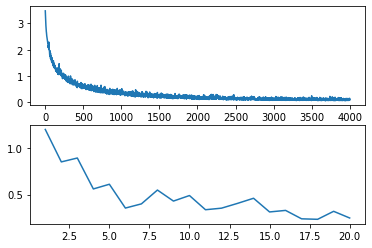

In [206]:
#plot loss
plt.figure(1)
plt.subplot(211)
plt.plot(range(2, len(train_loss)),train_loss[2:])
plt.subplot(212)
plt.plot(range(1, len(validation_loss)+1),validation_loss)


In [207]:
inputs,targets = get_batch_all(images_all_test,pairs_all_test,labels_all_test,1000,0)
model.evaluate(inputs,targets )

32/32 [==============================] - 1s 21ms/step - loss: 0.2699 - accuracy: 0.9450


[0.2699025869369507, 0.9449999928474426]

## Training on less represented class

In [234]:
less_represented={}
for m in sizes:
  if len(sizes[m]) <= 20:
    less_represented[m]=sizes[m]

In [250]:
ccc=[]
for m in sizes:
  if len(sizes[m]) <= 20:
    ccc.append(m)
print(len(ccc))

106


In [239]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32 #64#32
n_iter = 2000 #5400 # No. of training iterations 20000
N_way = 20 # how many classes for testing one-shot tasks
n_val = 256 # how many one-shot tasks to validate on
best = -1
epochs=2

In [255]:
optimizer = Adam(lr = 0.01)
model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [256]:
print("Starting training process for the less represented classes !")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = createPairs(X,y,less_represented,batch_size)
    targets=np.asarray(targets)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}, accuracy : {1}".format(loss[0],loss[1])) 
#         val_acc = test_oneshot(model,Xval,yval,sizes_val, N_way, n_val, verbose=True)
        val_acc = test_accuracy_score(n_val,Xval,yval,anchor_img,anchor_label,model,sizes_val)
        # model.save_weights(os.path.join(model_2_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process for the less represented classes !
-------------------------------------

 ------------- 

Time for 200 iterations: 0.18416974147160847 mins
Train Loss: 4.3526716232299805, accuracy : 0.65625
Got an average of 0.0% accuracy in 256 samples. 


 ------------- 

Time for 400 iterations: 0.8750580668449401 mins
Train Loss: 2.4980878829956055, accuracy : 0.5
Got an average of 1.171875% accuracy in 256 samples. 


 ------------- 

Time for 600 iterations: 1.546055785814921 mins
Train Loss: 1.76645827293396, accuracy : 0.5
Got an average of 0.390625% accuracy in 256 samples. 


 ------------- 

Time for 800 iterations: 2.1766769647598267 mins
Train Loss: 1.3561127185821533, accuracy : 0.5
Got an average of 0.390625% accuracy in 256 samples. 


 ------------- 

Time for 1000 iterations: 2.84729346036911 mins
Train Loss: 1.1597553491592407, accuracy : 0.5


KeyboardInterrupt: ignored

## loading model from weights

In [ ]:
# model_path=

In [ ]:
# model.save_weights(os.path.join('./', 'weights.h5'))

In [257]:
model.load_weights(os.path.join(data_path,'weights.20000.h5'))

# language model

In [ ]:
# !pip install ipynb

In [ ]:
from ipynb.fs.full.Language_model import lm_next


In [ ]:
import dill as pickle
with open("language_model.pkl", "rb") as f:
    language_model = pickle.load(f)

In [ ]:
prev=['M29', 'G1'] 
prediction=lm_next(language_model,prev)

In [ ]:
# prediction

In [ ]:
def choose_next(clf_3,score_3,language_model,prev):
#     print("prev",str(prev))
    
    freq=lm_next(language_model,prev)
#     print(freq)
    freq_3=[]
    for pred in clf_3:
        if pred in freq.keys():
            freq_3.append(freq[pred])
        else:
            freq_3.append(0)
    freq_3=np.array(freq_3)
    score_3 =np.array(score_3).flatten()
    #create a function to take the freq weights into consideration
    freq_3 = freq_3/np.sum(freq_3)
#     print(score_3.flatten())
    score_3 = score_3 / np.sum(score_3)
#     print(freq_3)
    
    scores = score_3 + freq_3
#     print('scores : ',scores)
    predicted=clf_3[np.argmax(scores)]
    print("clf predicted : ",clf_3[-1]," lm freq max : ",list(freq.keys())[0], " final : ",predicted)
    return predicted

In [ ]:
def predict_lm(Xtest,anchor_img,anchor_label,model,language_model,sizes):
    preds=[]
    for new in Xtest:
        if len(preds) < 2 :
            predicted,anchor_imgs,targets=whichGlyph(model,new,anchor_img,anchor_label)
            sort_index = np.argsort(np.asarray(predicted).reshape(len(predicted),))
            targ=targets[sort_index[-1]]
            print(targ)
            if targ =='UNKNOWN':
                targ=targets[sort_index[-2]] 
            preds.append(targ)
        else:
            predicted,anchor_imgs,targets=whichGlyph(model,new,anchor_img,anchor_label)
            sort_index = np.argsort(np.asarray(predicted).reshape(len(predicted),))
#             print('target : ',targets[sort_index[-1:]])
            predicted = choose_next(targets[sort_index[-3:]],predicted[sort_index[-3:]],language_model,preds[-2:])
            preds.append(predicted)
    return preds


In [ ]:
def test_lm(Xtest,ytest,anchor_img,anchor_label,model,language_model,sizes):
    preds=predict_lm(Xtest,anchor_img,anchor_label,model,language_model,sizes)
    preds=np.asarray(preds)
    ytest=np.asarray(ytest)
    accuracy = sum(preds==ytest)/len(ytest)
    return accuracy

In [ ]:
image_lm_test=[]
word=['M17','G1','X1','F9','N5']
for w in word:
    ind = np.random.choice(sizes_val[w])
    image_lm_test.append(Xval[ind])


In [ ]:
test_lm(image_lm_test,word,anchor_img,anchor_label,model,language_model,sizes)

M17
G1
clf predicted :  X1  lm freq max :  X1  final :  X1
clf predicted :  Q3  lm freq max :  Q3  final :  Q3
clf predicted :  O50  lm freq max :  None  final :  W24


/home/asmaa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


0.6

## Multi anchor array

In [ ]:
def create_multi_anchor(N,X,sizes):
  multi_anchor_img=[]
  multi_anchor_label=[]
  for n in range(N):
    anchor_img, anchor_label=create_glyphlist(X,sizes)
    multi_anchor_img.append(anchor_img)
    multi_anchor_label.append(anchor_label)
  return np.asarray(multi_anchor_img),np.asarray(multi_anchor_label)

In [ ]:
multi_anchor_img,multi_anchor_label=create_multi_anchor(3,X,sizes)

array([ 3,  7, 12])

In [208]:
def test_multi_anchor_random(N,Xval,yval,multi_anchor_img,multi_anchor_label,model,sizes):
  count_first=0
  multi_N=multi_anchor_img.shape[0]
  final_scores=np.zeros((multi_anchor_label[0].shape[0],1))
  for i in range(N):
    if i%100 == 0:
      print("test ",i)
    random_key = random.choice(list(sizes))
    ind = np.random.choice(sizes[random_key])
    # print(yval[ind][0])
    for j in range(multi_N):
      predicted,anchor_imgs,targets=whichGlyph(model,Xval[ind],multi_anchor_img[j],multi_anchor_label[j])
      zipped_lists = zip(targets,predicted)
      sorted_pairs = sorted(zipped_lists)
      tuples = zip(*sorted_pairs)
      targets,predicted = [ list(tuple) for tuple in  tuples]
      # print(targets[:3]," - ",predicted[:3])
      final_scores = np.asarray(final_scores) + np.asarray(predicted)

    final_pred = targets[np.argmax(final_scores)]
    # print(final_pred ,'  - ', yval[ind][0],' - ',count_first)
    if final_pred == yval[ind][0]:
        count_first+=1
    final_scores=np.zeros((multi_anchor_label[0].shape[0],1))
    
  percent_correct = (100.0 * count_first / N)
  return percent_correct



In [ ]:
t_start = time.time()
acc=test_multi_anchor_random(1000,Xval,yval,multi_anchor_img,multi_anchor_label,model,sizes_val)
print(f'testing:\nfound first accuracy with multi anchors = {acc}')
print("accuracy fn took {0} mins".format((time.time()-t_start)/60.0))

test  0
test  100
test  200
test  300
test  400
test  500
test  600
test  700
test  800
test  900
testing:
found first accuracy with multi anchors = 63.2
accuracy fn took 6.661158684889475 mins


In [222]:

    # print(m,":",len(sizes[m]))

# Some Testing

In [258]:
t_start = time.time()
acc1,acc3=calc_accuracy(1000,Xval,yval,anchor_img,anchor_label,model,sizes_val)
print(f'testing:\nfound first accuracy = {acc1} , first 3 accuracy = {acc3}')
print("accuracy fn took {0} mins".format((time.time()-t_start)/60.0))

testing:
found first accuracy = 0.626 , first 3 accuracy = 0.872
accuracy fn took 2.1001135031382243 mins


In [ ]:
t_start = time.time()
acc1,acc3=calc_accuracy(250,X,y,anchor_img,anchor_label,model,sizes)
print(f'training:\nfound first accuracy = {acc1} , first 3 accuracy = {acc3} ')
print("accuracy fn took {0} mins".format((time.time()-t_start)/60.0))

training:
found first accuracy = 0.996 , first 3 accuracy = 1.0 
accuracy fn took 0.5483039061228434 mins


In [210]:
t_start = time.time()
y_pred,y_true= predict_random(1000,Xval,yval,anchor_img,anchor_label,model,sizes_val)
print("accuracy fn took {0} mins".format((time.time()-t_start)/60.0))

accuracy fn took 2.0673663139343263 mins


In [211]:
# confusion_matrix = pd.crosstab(index=y_true, columns=y_pred, rownames=['True'], colnames=['predictions']).astype(int)
# sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

        Aa15       0.00      0.00      0.00         6
        Aa26       1.00      1.00      1.00         6
        Aa27       0.00      0.00      0.00        11
          D1       0.00      0.00      0.00        10
         D10       0.00      0.00      0.00        11
        D156       0.46      1.00      0.63         6
         D19       0.00      0.00      0.00         3
          D2       0.00      0.00      0.00        11
         D21       1.00      0.92      0.96        12
         D28       0.56      0.56      0.56         9
         D35       0.86      0.86      0.86         7
         D36       1.00      0.78      0.88         9
         D39       0.00      0.00      0.00         8
          D4       0.67      0.67      0.67         9
         D46       0.12      0.14      0.13         7
         D52       0.00      0.00      0.00         9
         D54       0.00      0.00      0.00         7
         D56       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y[y=='UNKNOWN'].shape

(125,)

In [ ]:
# t_start = time.time()
# print(calc_accuracy(1,Xval,yval,anchor_img,anchor_label,model))
# print("accuracy fn took {0} sec".format((time.time()-t_start)))

### Testing new images

In [ ]:
def preprocess(img):
    if len(img.shape) == 3 and img.shape[2]==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    img = cv2.resize(img,(50,75))
    return img

(75, 50)


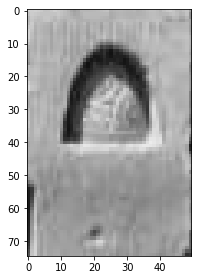

In [ ]:
test_img1=io.imread('3.jpg')
test_img1=preprocess(test_img1)
print(test_img1.shape)
io.imshow(test_img1)


In [ ]:
print(targets[64])
targets

X1


array(['U33', 'Q1', 'Y3', 'D39', 'N17', 'G29', 'G26', 'M23', 'Z1', 'M40',
       'D21', 'W18', 'T30', 'F34', 'G7', 'M12', 'W24', 'G39', 'M20',
       'N25', 'V7', 'D2', 'Y2', 'E34', 'E23', 'G40', 'N5', 'N18', 'G37',
       'W25', 'F18', 'D60', 'T20', 'G1', 'V28', 'N35', 'U1', 'N41',
       'M195', 'D56', 'D10', 'Q3', 'G36', 'D28', 'T21', 'W11', 'G25',
       'F31', 'E9', 'Q7', 'O34', 'M17', 'I10', 'Y5', 'V24', 'N30', 'X8',
       'S24', 'M41', 'N14', 'UNKNOWN', 'G35', 'S28', 'P6', 'X1', 'V30',
       'N29', 'Z7', 'R8', 'D156', 'V4', 'F16', 'D58', 'N31', 'G14', 'G17',
       'F13', 'F4', 'P98', 'D46', 'V31', 'G4', 'F9', 'D35', 'M1', 'O50',
       'O4', 'F35', 'P8', 'O31', 'S34', 'D4', 'M16', 'R4', 'O28', 'M3',
       'N36', 'Z11', 'N1', 'D36', 'D1', 'W22', 'D52', 'O49', 'M29', 'D19',
       'V6', 'U15', 'F26', 'G5', 'M44', 'M42', 'G43', 'U7', 'N37', 'T22',
       'H6', 'L1', 'E1', 'S29', 'I9', 'Aa27', 'T28', 'G21', 'M8', 'U28',
       'O1', 'Aa26', 'Aa15', 'F40', 'W19', 'P1', 'M18', 'D5

In [ ]:
predicted[100]

array([0.65185916], dtype=float32)

In [ ]:
predicted,anchor_imgs,targets=whichGlyph(model,test_img1.reshape(75,50,1),anchor_img,anchor_label)

In [ ]:
sort_index = np.argsort(np.asarray(predicted).reshape(len(predicted),))
sort_index 

array([ 57,  22,  39, 121, 116,  20,  97, 125,  30,  62,  90,  15, 110,
        98,  29, 130,  50, 104,  93,  92, 111,   5,  86,  37,  56,  76,
       106,  59,  31,  83, 115, 122,  73, 134,  34,  44,  88,  72,  27,
         1, 107,  65,  87,  32,  89,  95,  55,  67, 133,  77,  94, 129,
       114,  38,  81,  49, 101,  11,   0,  63, 131, 132, 117,  19,  54,
        91, 127,   4, 108,  70,  99,  69,  46,  28,  84,   6,   2,  17,
       126, 113,  78,  40,  51, 124,  74,  79, 103,   3, 128,   7,   9,
         8,  24, 118,  43,  47,  35,  96,  18,  82, 119, 120, 105,  13,
        36, 102,  68,  66,  48,  42,  21,  61,  33,  25,  10,  52,  71,
        64, 109,  23,  75,  53,  14,  60,  12,  45, 123, 112,  80,  26,
        85,  58,  41,  16, 100])

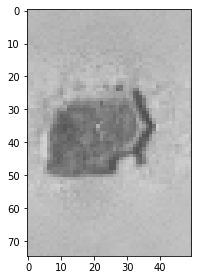

In [ ]:
io.imshow(anchor_imgs[100].reshape(75,50))